Data Retrieval

In [1]:
import pickle
import numpy as np
def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

labels = []
data = []
for i in files: 
    fileph = "data_preprocessed_python/s" + i + ".dat"
    d = read_data(fileph)
    labels.append(d['labels'])
    data.append(d['data'])

Data Reshaping

In [2]:
labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)

(32, 40, 4)
(32, 40, 40, 8064)


In [3]:
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)

(1280, 4)
(1280, 40, 8064)


In [4]:
eeg_data = data[:,:32,:]
print(eeg_data.shape)

(1280, 32, 8064)


Data Pre Processing

In [5]:
from scipy.signal import welch
from scipy.integrate import simps
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "delta"):
        bd = (0.5,4)
    if (band == "theta"):
        bd = (4,8)
    elif (band == "alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    return bandpower(eeg_data[people,channel], 128, bd)

Data Visualization

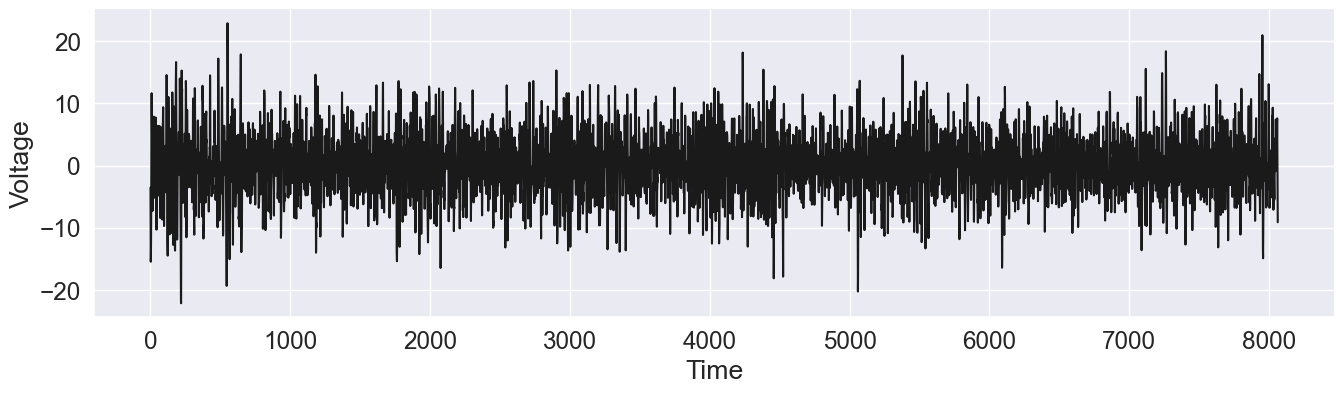

In [6]:
import seaborn as sns
sns.set(font_scale=1.6)

sf = 128.
time = np.arange(eeg_data.size) / sf

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[1,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

In [7]:
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [8]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [9]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [10]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [11]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


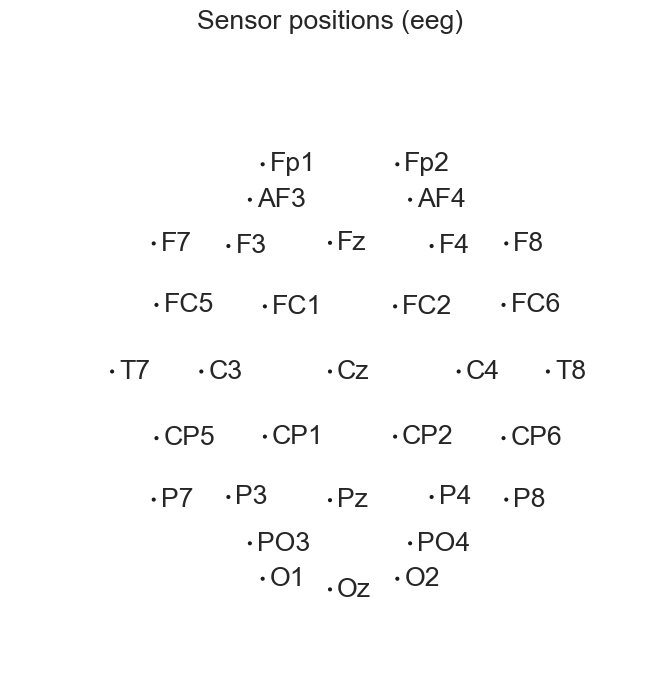

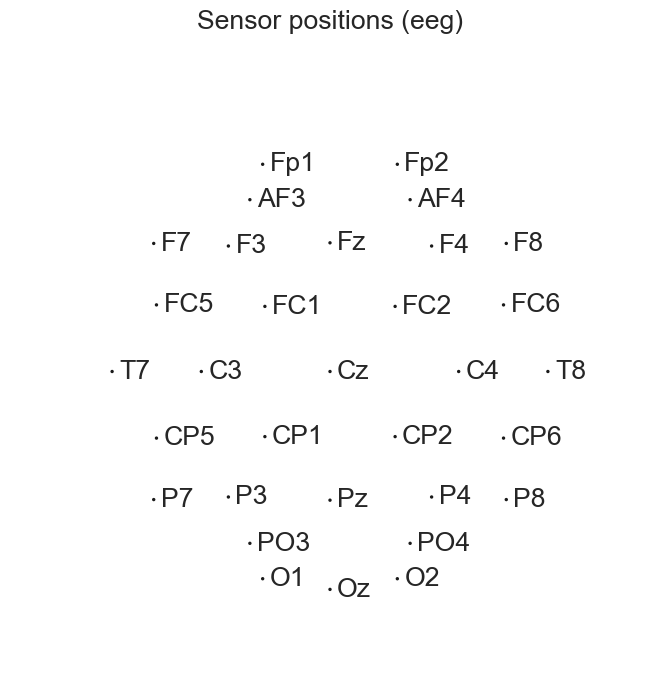

In [12]:
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

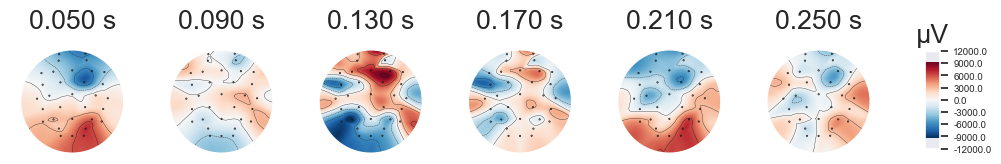

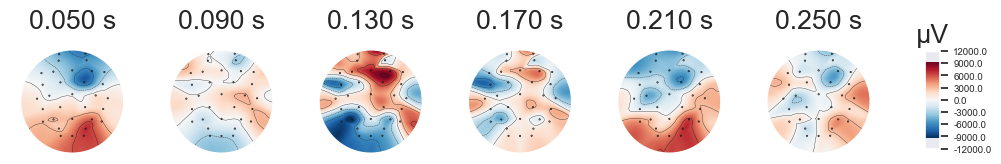

In [13]:
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

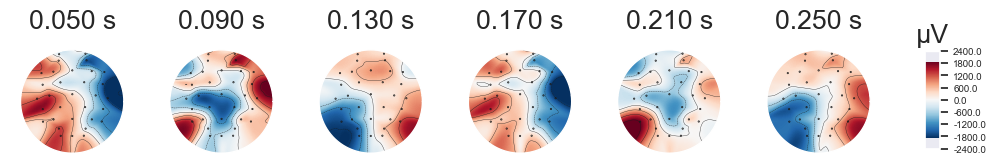

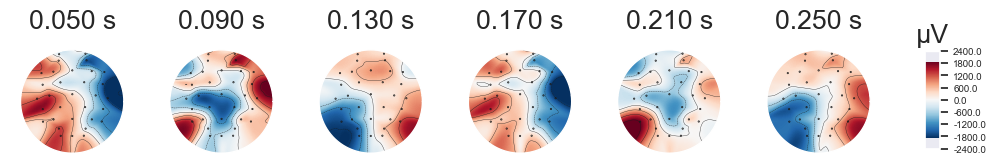

In [14]:
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

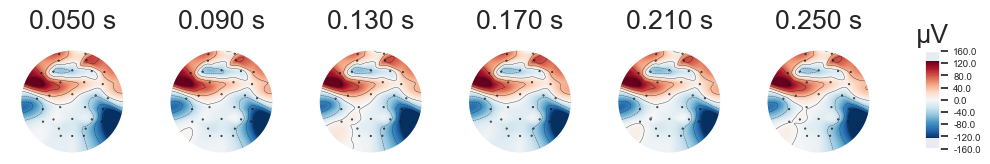

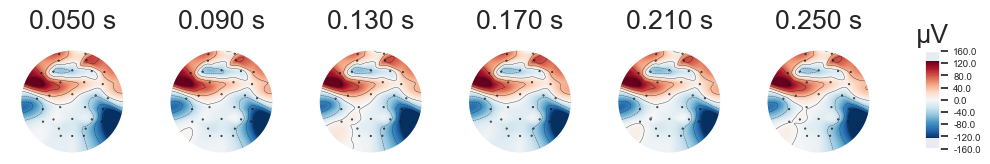

In [15]:
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\filter.py:1702: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

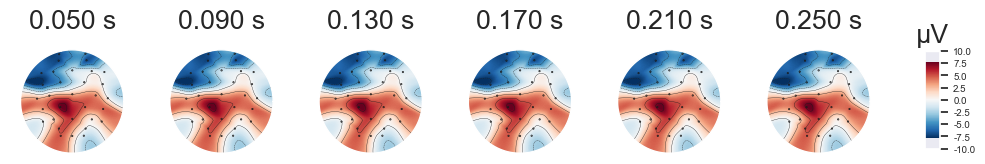

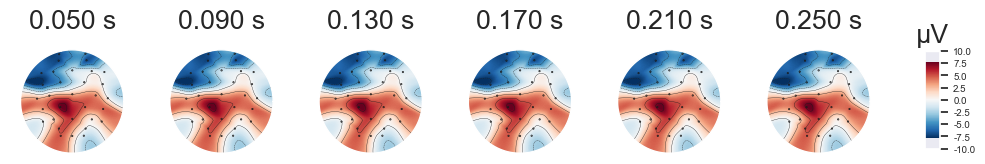

In [16]:
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

In [17]:
eeg_band = []
for i in range (len(eeg_data)):
    for j in range (len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"delta"))
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))

In [18]:
eeg_band = np.array(eeg_band)
eeg_band = eeg_band.reshape((1280,160)) # 5×32
print(eeg_band.shape)

(1280, 160)


In [19]:
import pandas as pd
df_label = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1], 
                        'Dominance': labels[:,2], 'Liking': labels[:,3]})
df_label

,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
...,...,...,...,...
1275,3.91,6.96,5.82,3.12
1276,2.81,6.13,6.06,1.04
1277,3.05,7.01,5.10,1.10
1278,3.99,7.17,4.85,1.00


In [20]:

df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Valence    1280 non-null   float64
 1   Arousal    1280 non-null   float64
 2   Dominance  1280 non-null   float64
 3   Liking     1280 non-null   float64
dtypes: float64(4)
memory usage: 40.1 KB


In [21]:
df_label.describe()

,Valence,Arousal,Dominance,Liking
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [22]:
label_name = ["valence","arousal","dominance","liking"]
labels_valence = []
labels_arousal = []
labels_dominance = []
labels_liking = []
for la in labels:
    l = []
    if la[0]>5:
        labels_valence.append(1)
    else:
        labels_valence.append(0)
    if la[1]>5:
        labels_arousal.append(1)
    else:
        labels_arousal.append(0)
    if la[2]>5:
        labels_dominance.append(1)
    else:
        labels_dominance.append(0)
    if la[3]>6:
        labels_liking.append(1)
    else:
        labels_liking.append(0)

In [23]:
data_x = eeg_band
print(data_x.shape)
X = data_x
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
print(X.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components=110)
X=pca.fit_transform(X)
print(X.shape)

(1280, 160)
(1280, 160)
(1280, 110)


Arousal

In [24]:
label_y = labels_arousal
trainscores = []
testscores = []

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_y)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_train)
y_test=np.array(y_train)

Deep Neural Network

In [26]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
model=Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model_history=model.fit(x=X_train, y=y_train, epochs=300,validation_split=0.22, verbose=1)

Epoch 1/300


24/24 [==============================] - 2s 12ms/step - loss: 0.9914 - accuracy: 0.4385 - val_loss: 0.7670 - val_accuracy: 0.4481
Epoch 2/300
24/24 [==============================] - 0s 5ms/step - loss: 0.8526 - accuracy: 0.5120 - val_loss: 0.7336 - val_accuracy: 0.4623
Epoch 3/300
24/24 [==============================] - 0s 5ms/step - loss: 0.8161 - accuracy: 0.5120 - val_loss: 0.7148 - val_accuracy: 0.5377
Epoch 4/300
24/24 [==============================] - 0s 5ms/step - loss: 0.7963 - accuracy: 0.5107 - val_loss: 0.7040 - val_accuracy: 0.5142
Epoch 5/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7951 - accuracy: 0.4880 - val_loss: 0.6965 - val_accuracy: 0.5142
Epoch 6/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7583 - accuracy: 0.5267 - val_loss: 0.6897 - val_accuracy: 0.5283
Epoch 7/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7399 - accuracy: 0.5134 - val_loss: 0.6825 - val_accuracy: 0.5330
Epoch 8/30

<Axes: >

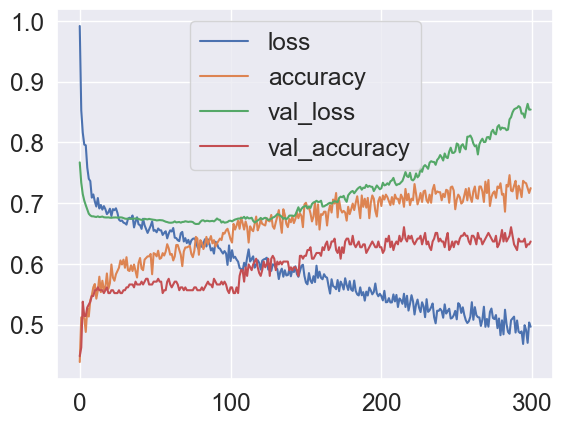

In [28]:
import matplotlib.pyplot as plt
model_loss=pd.DataFrame(model.history.history)
model_loss.plot()

In [29]:
y_pred=model.predict(X_test)

30/30 [==============================] - 0s 1ms/step


In [30]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

Results

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[259 159]
 [ 71 471]]


              precision    recall  f1-score   support

           0       0.78      0.62      0.69       418
           1       0.75      0.87      0.80       542

    accuracy                           0.76       960
   macro avg       0.77      0.74      0.75       960
weighted avg       0.76      0.76      0.76       960



[Text(0, 0.5, 'No Arousal'), Text(0, 1.5, 'Arousal')]

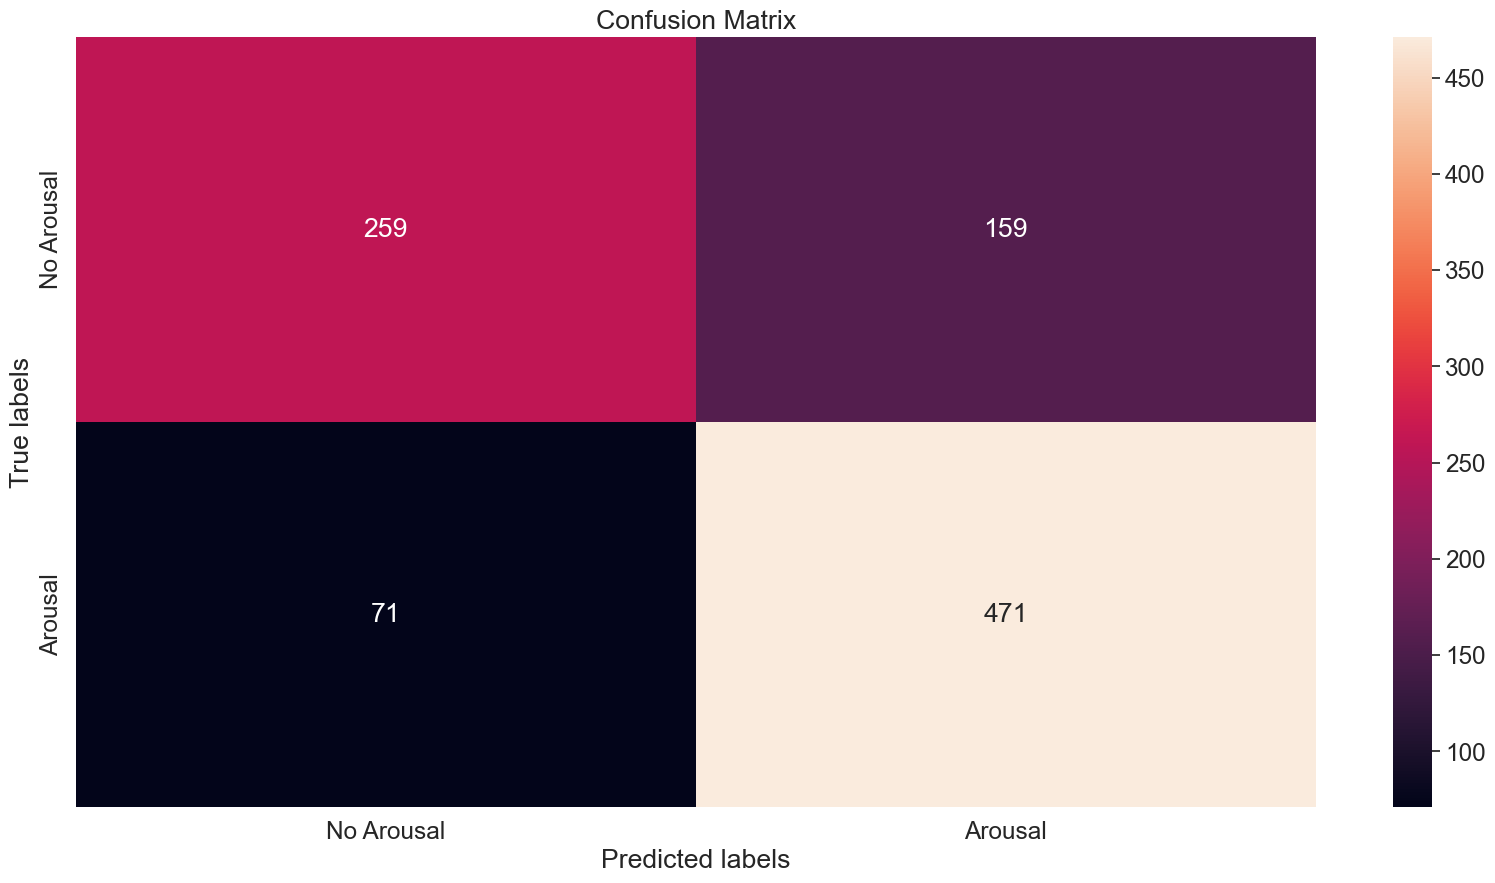

In [32]:
import seaborn as sns
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Arousal', 'Arousal']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

Model Ensemble

In [33]:
from sklearn.neighbors import KNeighborsClassifier
import xgboost 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [34]:
dtcla =  DecisionTreeClassifier()
rfcla = RandomForestClassifier()
knnei =  KNeighborsClassifier()
xgboo = xgboost.XGBClassifier()

clffr = [dtcla,rfcla,knnei,xgboo]
for algor in clffr:
    score = cross_val_score( algor,X_train,y_train,cv = 5,scoring = 'accuracy')
    print("The accuracy score of {} is:".format(algor),score.mean())

clffr = [('dtc',dtcla),('rfc',rfcla),('knn',knnei),('xgb',xgboo)]
from sklearn.ensemble import StackingClassifier
lrre = LogisticRegression()
stack_model1 = StackingClassifier( estimators = clffr,final_estimator = lrre)
score = cross_val_score(stack_model1,X_train,y_train,cv = 5,scoring = 'accuracy')

The accuracy score of DecisionTreeClassifier() is: 0.5729166666666666
The accuracy score of RandomForestClassifier() is: 0.6385416666666667
The accuracy score of KNeighborsClassifier() is: 0.6229166666666666
The accuracy score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) is: 0.622916666666

In [35]:
stack_model1.fit(X_train, y_train)

StackingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                               ('rfc', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, ga...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [36]:
stack_result=stack_model1.predict(X_test)

In [37]:
print(confusion_matrix(y_test, stack_result))
print('\n')
print(classification_report(y_test, stack_result))

[[418   0]
 [  0 542]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       418
           1       1.00      1.00      1.00       542

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



[Text(0, 0.5, 'No Arousal'), Text(0, 1.5, 'Arousal')]

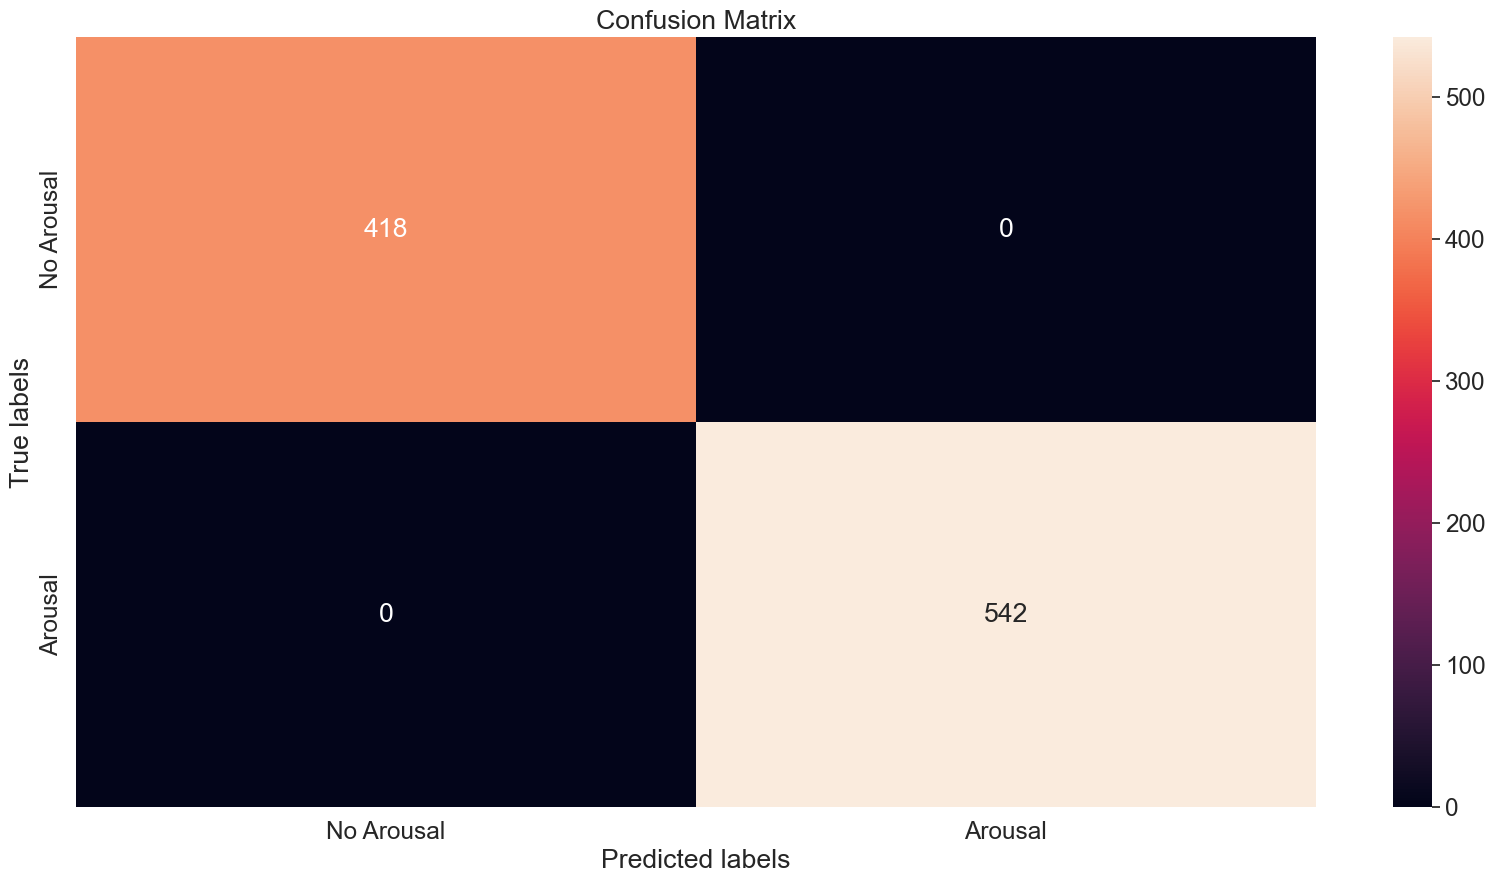

In [38]:
cm=confusion_matrix(y_test, stack_result)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Arousal', 'Arousal']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

Valence

(1280, 160)
Epoch 1/300
24/24 [==============================] - 1s 11ms/step - loss: 0.8571 - accuracy: 0.5134 - val_loss: 0.7078 - val_accuracy: 0.5660
Epoch 2/300
24/24 [==============================] - 0s 4ms/step - loss: 0.8886 - accuracy: 0.5160 - val_loss: 0.7003 - val_accuracy: 0.5755
Epoch 3/300
24/24 [==============================] - 0s 4ms/step - loss: 0.8023 - accuracy: 0.5187 - val_loss: 0.6928 - val_accuracy: 0.5943
Epoch 4/300
24/24 [==============================] - 0s 4ms/step - loss: 0.8056 - accuracy: 0.5321 - val_loss: 0.6875 - val_accuracy: 0.5943
Epoch 5/300
24/24 [==============================] - 0s 4ms/step - loss: 0.8108 - accuracy: 0.5321 - val_loss: 0.6842 - val_accuracy: 0.5849
Epoch 6/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7637 - accuracy: 0.5160 - val_loss: 0.6824 - val_accuracy: 0.5802
Epoch 7/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7381 - accuracy: 0.5455 - val_loss: 0.6827 - val_accuracy: 0.5849


[Text(0, 0.5, 'No Valence'), Text(0, 1.5, 'Valence')]

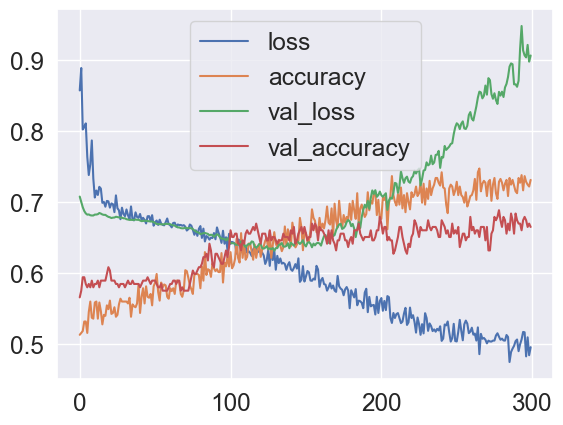

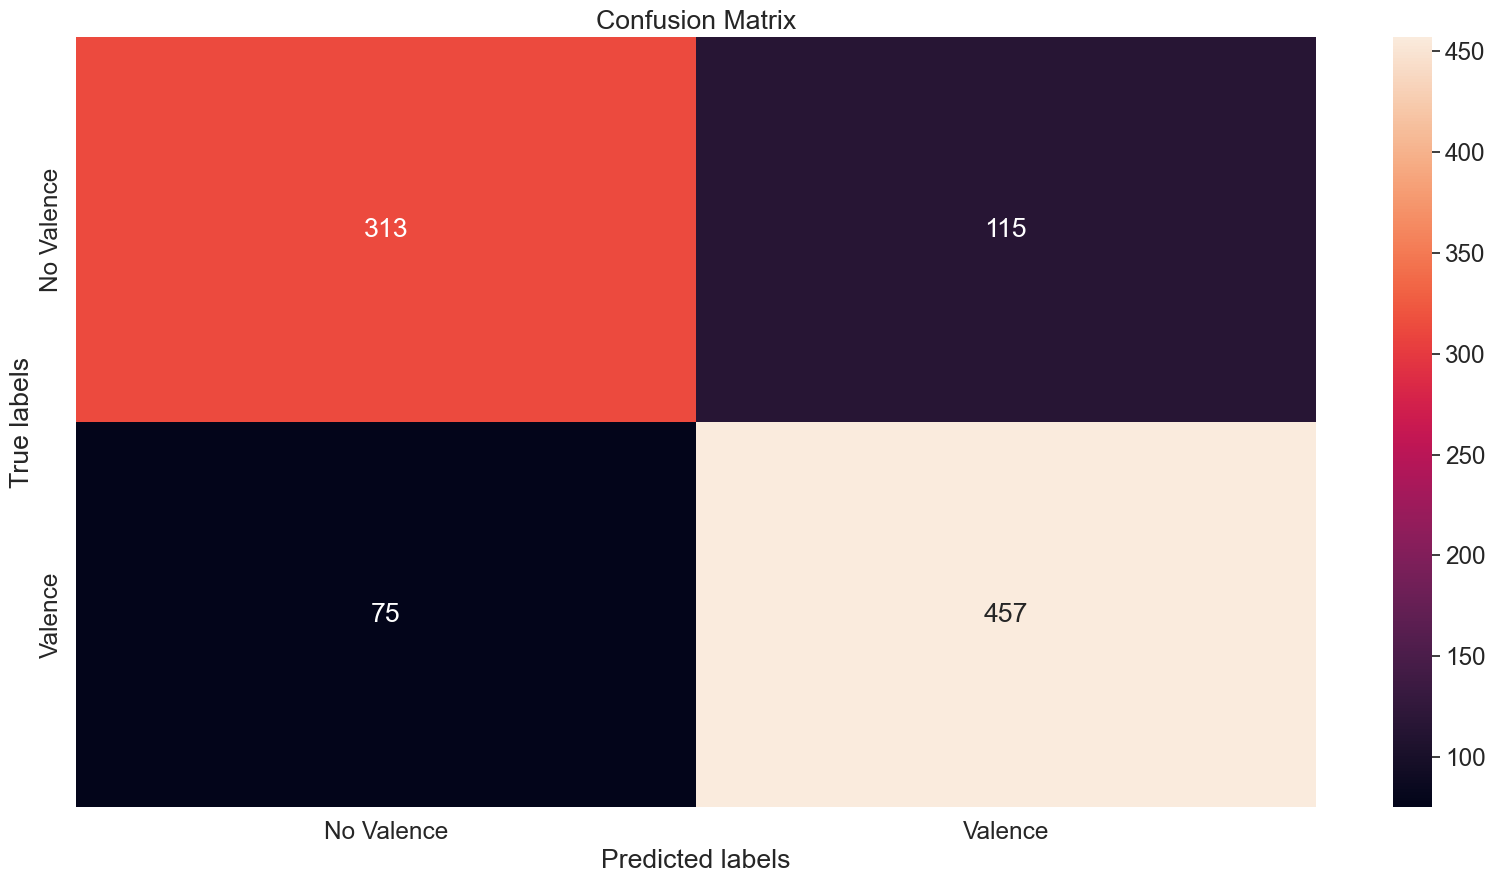

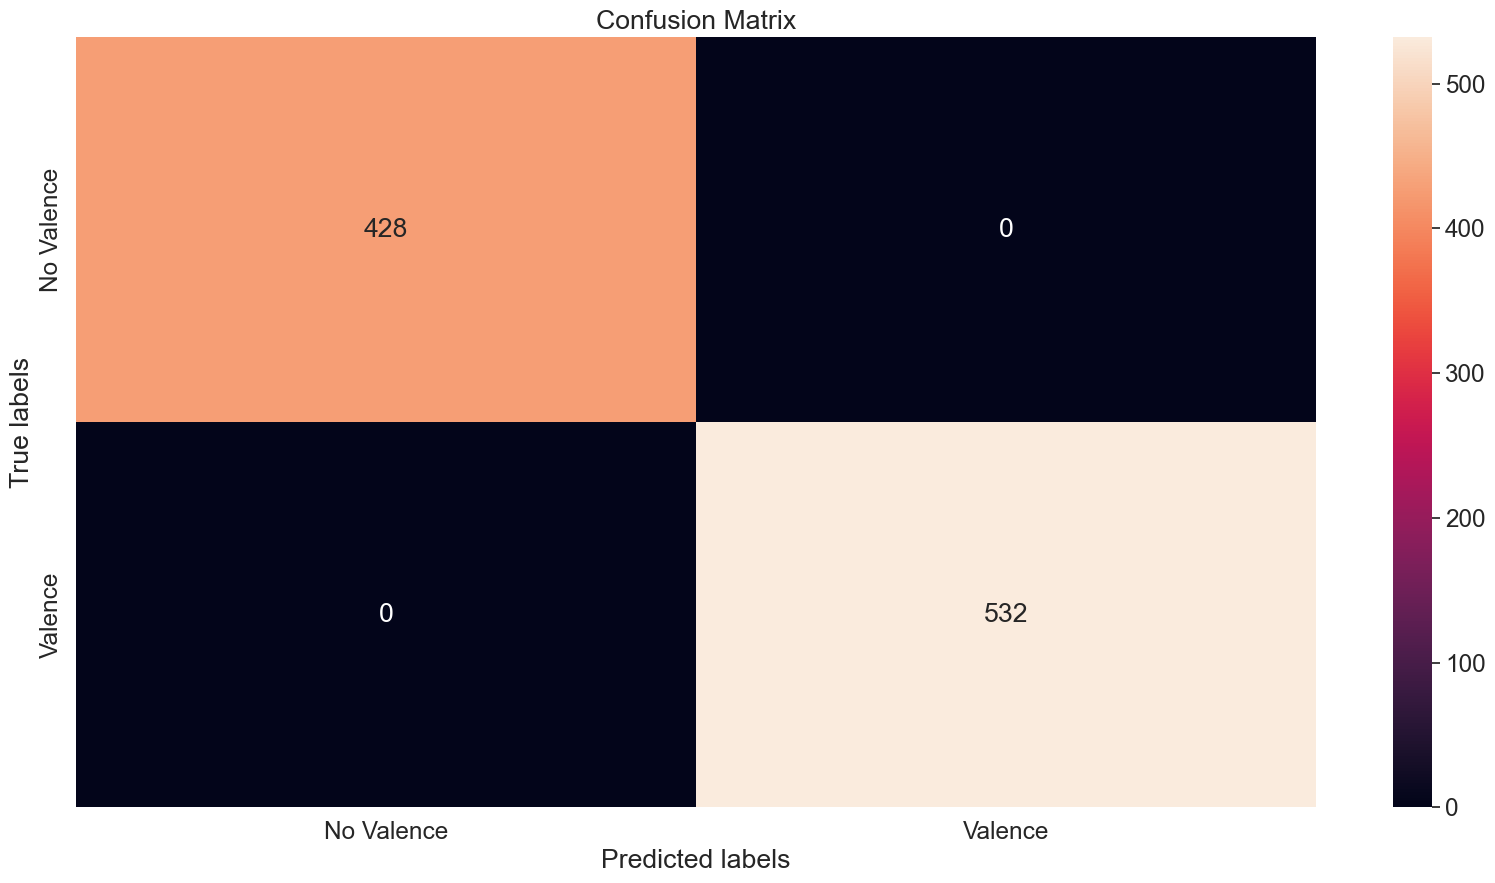

In [39]:
data_x = eeg_band
print(data_x.shape)
label_y = labels_valence
trainscores = []
testscores = []


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_y)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_train)
y_test=np.array(y_train)


from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
model=Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model_history=model.fit(x=X_train, y=y_train, epochs=300,validation_split=0.22, verbose=1)


import matplotlib.pyplot as plt
model_loss=pd.DataFrame(model.history.history)
model_loss.plot()


y_pred=model.predict(X_test)


y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))


import seaborn as sns
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Valence', 'Valence']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)


dtcla =  DecisionTreeClassifier()
rfcla = RandomForestClassifier()
knnei =  KNeighborsClassifier()
xgboo = xgboost.XGBClassifier()

clffr = [dtcla,rfcla,knnei,xgboo]
for algor in clffr:
    score = cross_val_score( algor,X_train,y_train,cv = 5,scoring = 'accuracy')
    print("The accuracy score of {} is:".format(algor),score.mean())

clffr = [('dtc',dtcla),('rfc',rfcla),('knn',knnei),('xgb',xgboo)]
from sklearn.ensemble import StackingClassifier
lrre = LogisticRegression()
stack_model1 = StackingClassifier( estimators = clffr,final_estimator = lrre)
score = cross_val_score(stack_model1,X_train,y_train,cv = 5,scoring = 'accuracy')


stack_model1.fit(X_train, y_train)


stack_result=stack_model1.predict(X_test)


print(confusion_matrix(y_test, stack_result))
print('\n')
print(classification_report(y_test, stack_result))


cm=confusion_matrix(y_test, stack_result)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Valence', 'Valence']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

Dominance

(1280, 160)
Epoch 1/300
24/24 [==============================] - 1s 9ms/step - loss: 0.8730 - accuracy: 0.5013 - val_loss: 0.7802 - val_accuracy: 0.4481
Epoch 2/300
24/24 [==============================] - 0s 4ms/step - loss: 0.8748 - accuracy: 0.4933 - val_loss: 0.7455 - val_accuracy: 0.4670
Epoch 3/300
24/24 [==============================] - 0s 4ms/step - loss: 0.8670 - accuracy: 0.5201 - val_loss: 0.7062 - val_accuracy: 0.4858
Epoch 4/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7708 - accuracy: 0.5468 - val_loss: 0.6858 - val_accuracy: 0.4906
Epoch 5/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7198 - accuracy: 0.5655 - val_loss: 0.6742 - val_accuracy: 0.5849
Epoch 6/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7782 - accuracy: 0.5628 - val_loss: 0.6636 - val_accuracy: 0.6132
Epoch 7/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7459 - accuracy: 0.5816 - val_loss: 0.6525 - val_accuracy: 0.6368
E

[Text(0, 0.5, 'No Dominance'), Text(0, 1.5, 'Dominance')]

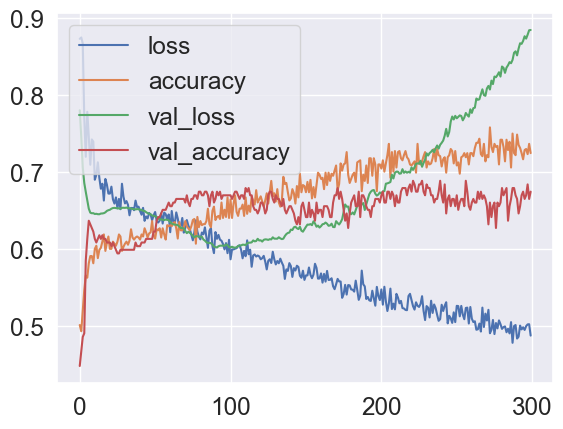

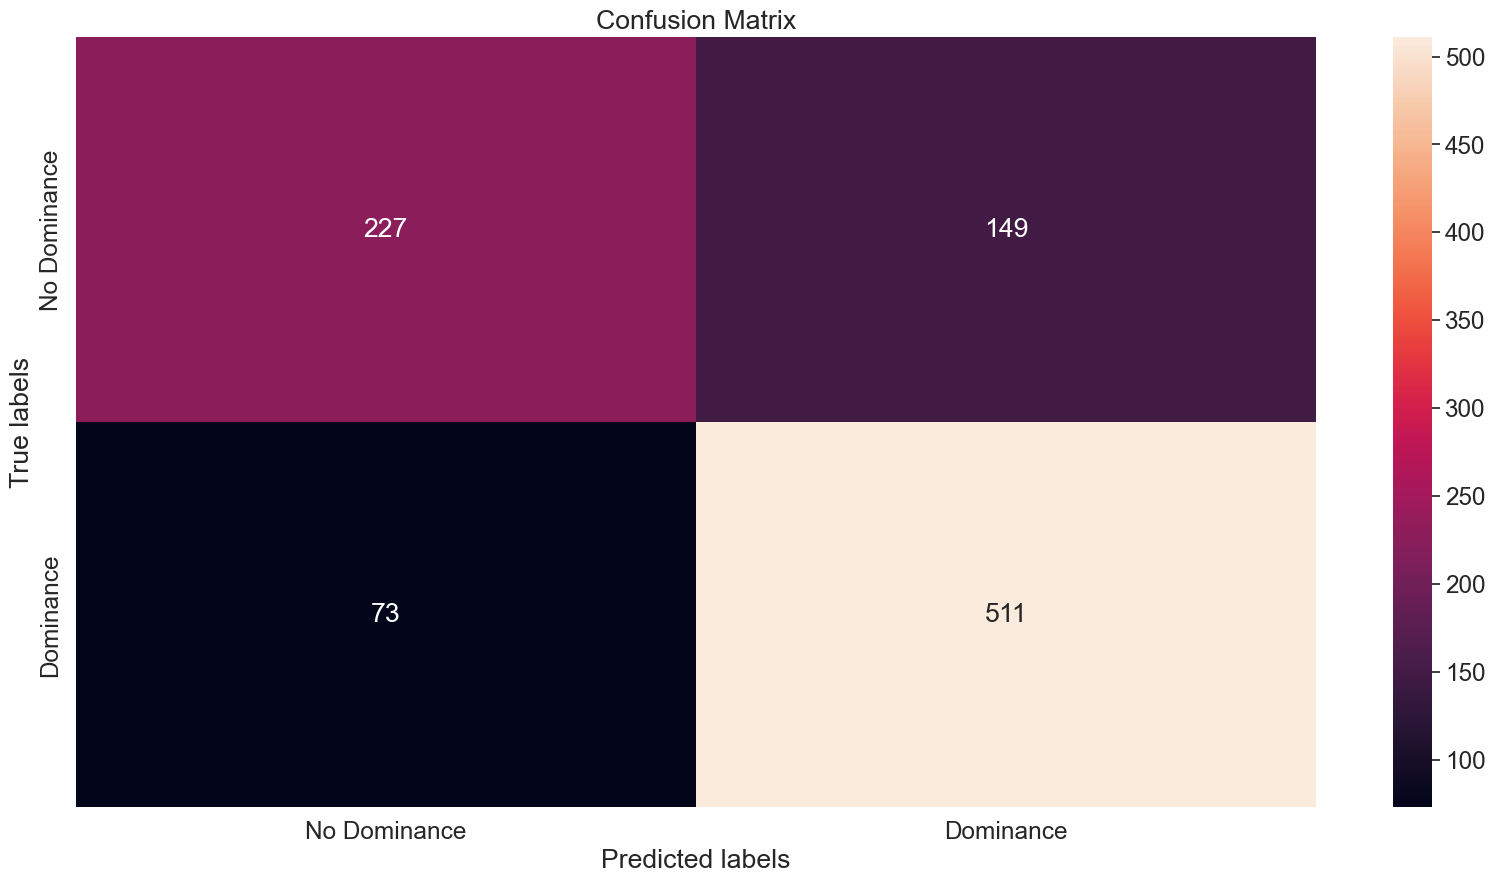

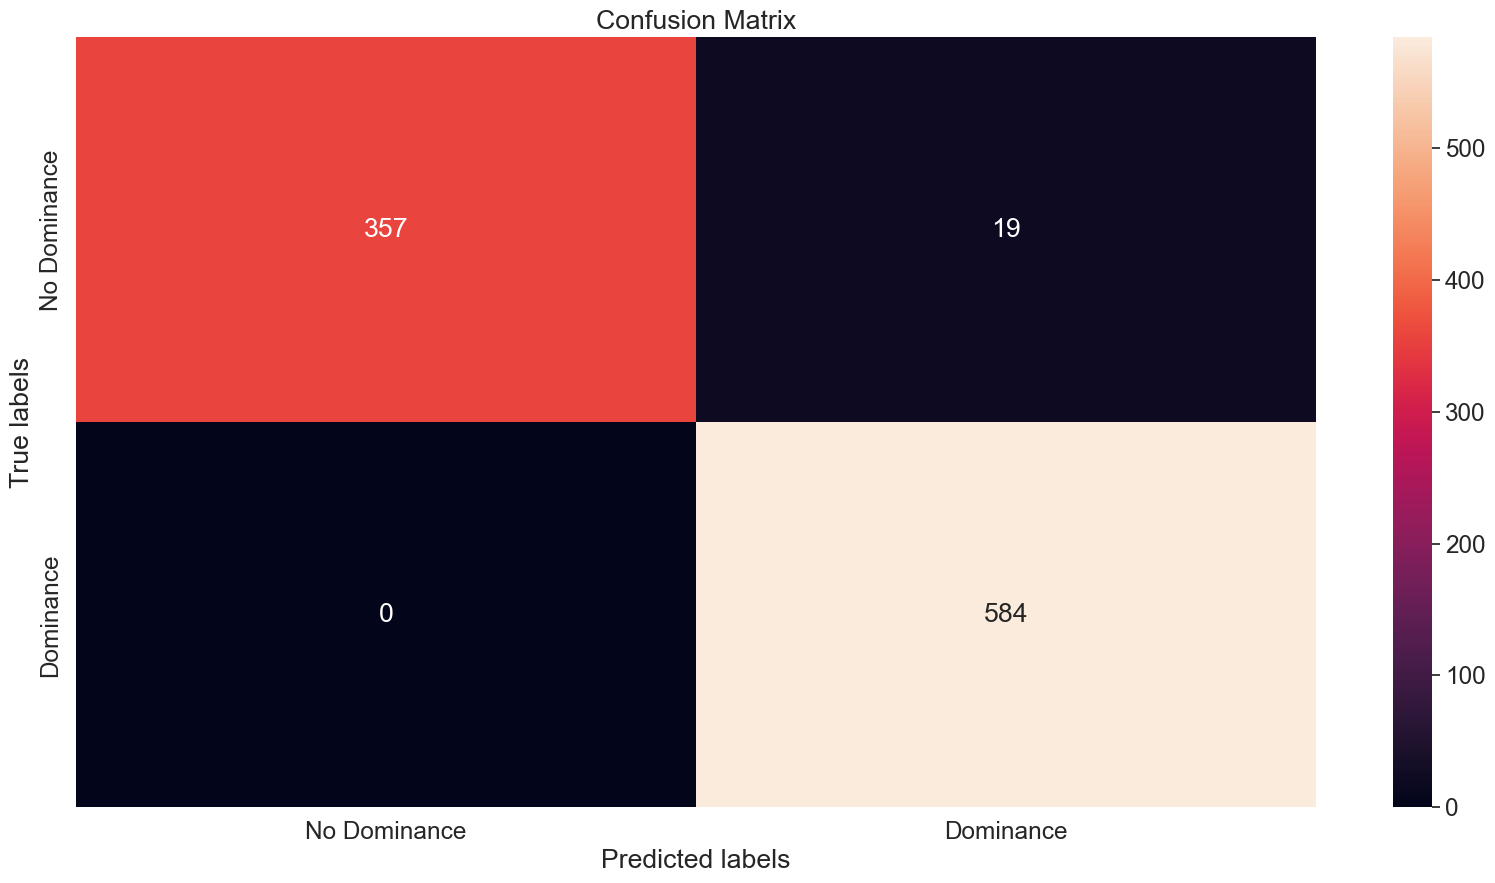

In [40]:
data_x = eeg_band
print(data_x.shape)
label_y = labels_dominance
trainscores = []
testscores = []


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_y)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_train)
y_test=np.array(y_train)


from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
model=Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model_history=model.fit(x=X_train, y=y_train, epochs=300,validation_split=0.22, verbose=1)


import matplotlib.pyplot as plt
model_loss=pd.DataFrame(model.history.history)
model_loss.plot()


y_pred=model.predict(X_test)


y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))


import seaborn as sns
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Dominance', 'Dominance']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)


dtcla =  DecisionTreeClassifier()
rfcla = RandomForestClassifier()
knnei =  KNeighborsClassifier()
xgboo = xgboost.XGBClassifier()

clffr = [dtcla,rfcla,knnei,xgboo]
for algor in clffr:
    score = cross_val_score( algor,X_train,y_train,cv = 5,scoring = 'accuracy')
    print("The accuracy score of {} is:".format(algor),score.mean())

clffr = [('dtc',dtcla),('rfc',rfcla),('knn',knnei),('xgb',xgboo)]
from sklearn.ensemble import StackingClassifier
lrre = LogisticRegression()
stack_model1 = StackingClassifier( estimators = clffr,final_estimator = lrre)
score = cross_val_score(stack_model1,X_train,y_train,cv = 5,scoring = 'accuracy')


stack_model1.fit(X_train, y_train)


stack_result=stack_model1.predict(X_test)


print(confusion_matrix(y_test, stack_result))
print('\n')
print(classification_report(y_test, stack_result))


cm=confusion_matrix(y_test, stack_result)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Dominance', 'Dominance']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

Liking

(1280, 160)
Epoch 1/300
24/24 [==============================] - 1s 10ms/step - loss: 0.7481 - accuracy: 0.4960 - val_loss: 0.6927 - val_accuracy: 0.4670
Epoch 2/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7847 - accuracy: 0.4572 - val_loss: 0.6864 - val_accuracy: 0.5236
Epoch 3/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7515 - accuracy: 0.4866 - val_loss: 0.6867 - val_accuracy: 0.5094
Epoch 4/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7187 - accuracy: 0.4840 - val_loss: 0.6882 - val_accuracy: 0.5142
Epoch 5/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7232 - accuracy: 0.5134 - val_loss: 0.6877 - val_accuracy: 0.5047
Epoch 6/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7250 - accuracy: 0.4906 - val_loss: 0.6897 - val_accuracy: 0.5189
Epoch 7/300
24/24 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.4826 - val_loss: 0.6897 - val_accuracy: 0.5189


[Text(0, 0.5, 'No Liking'), Text(0, 1.5, 'Liking')]

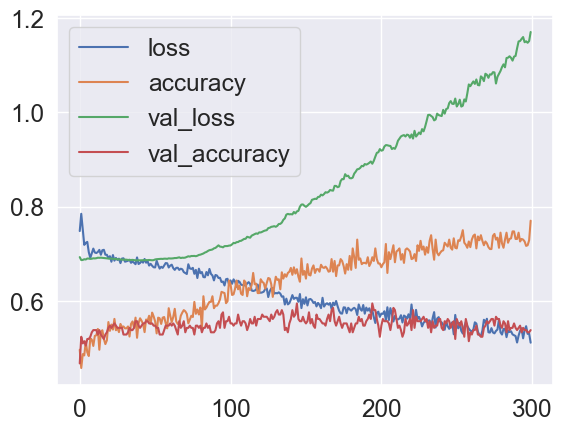

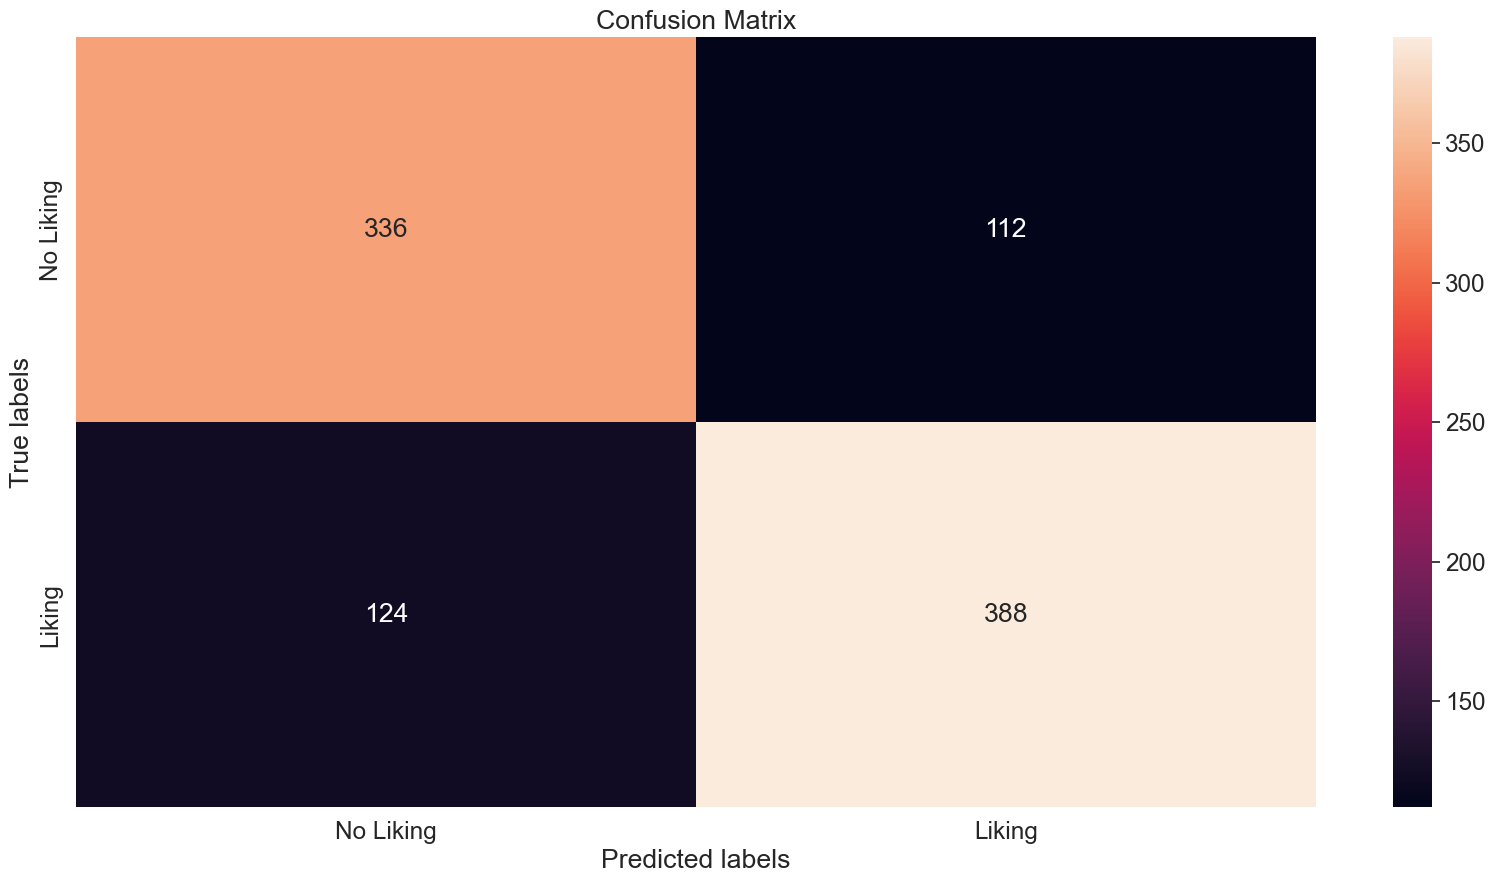

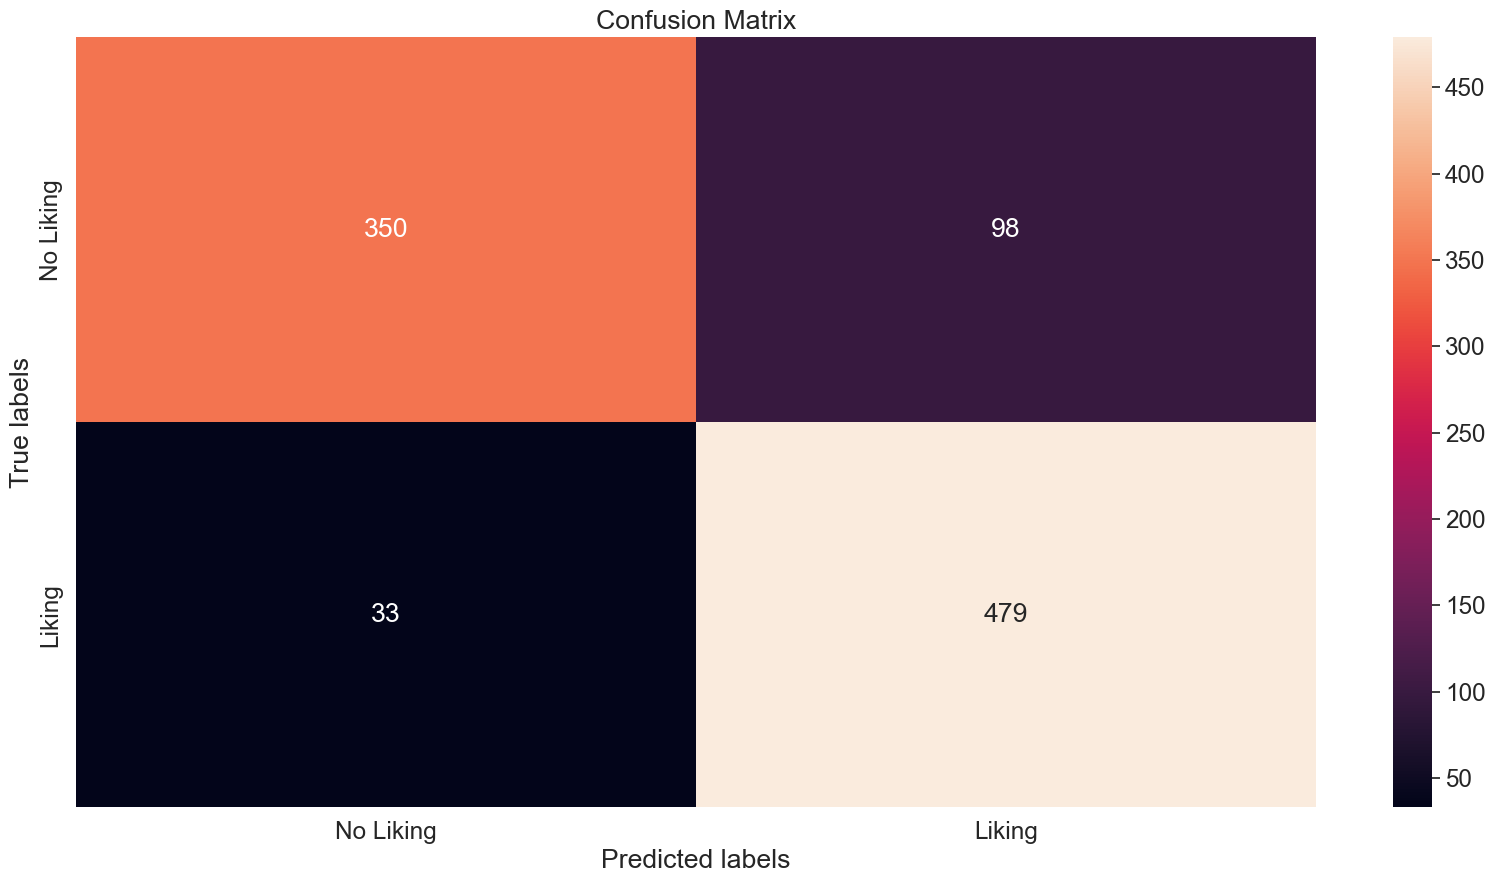

In [41]:
data_x = eeg_band
print(data_x.shape)
label_y = labels_liking
trainscores = []
testscores = []


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_y)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_train)
y_test=np.array(y_train)


from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
model=Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model_history=model.fit(x=X_train, y=y_train, epochs=300,validation_split=0.22, verbose=1)


import matplotlib.pyplot as plt
model_loss=pd.DataFrame(model.history.history)
model_loss.plot()


y_pred=model.predict(X_test)


y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0


from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))


import seaborn as sns
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Liking', 'Liking']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)


dtcla =  DecisionTreeClassifier()
rfcla = RandomForestClassifier()
knnei =  KNeighborsClassifier()
xgboo = xgboost.XGBClassifier()

clffr = [dtcla,rfcla,knnei,xgboo]
for algor in clffr:
    score = cross_val_score( algor,X_train,y_train,cv = 5,scoring = 'accuracy')
    print("The accuracy score of {} is:".format(algor),score.mean())

clffr = [('dtc',dtcla),('rfc',rfcla),('knn',knnei),('xgb',xgboo)]
from sklearn.ensemble import StackingClassifier
lrre = LogisticRegression()
stack_model1 = StackingClassifier( estimators = clffr,final_estimator = lrre)
score = cross_val_score(stack_model1,X_train,y_train,cv = 5,scoring = 'accuracy')


stack_model1.fit(X_train, y_train)


stack_result=stack_model1.predict(X_test)


print(confusion_matrix(y_test, stack_result))
print('\n')
print(classification_report(y_test, stack_result))


cm=confusion_matrix(y_test, stack_result)
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['No Liking', 'Liking']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)